# Location for Mining Well

**An aim of the research** — build machine learning models and calculate the revenue:
1. Data pre-processing for improving the correlation of input parameters
2. Application of Neural Network and Linear Regression models
3. Selection of optimal model hyper-parameters
4. Machine learning algorithms and model architecture
5. Models testing on 3 different datasets
6. Calculation of revenue and business risk assessment


**An initial data**

The dataframe is extracted from following files:
- `geo_data_0.csv` 
- `geo_data_1.csv` 
- `geo_data_2.csv` 

Since data cleaning has already been done on the dataset, no additional steps are required to work with the data.
 
The research is divided into five steps:
  1. Data overview
  2. Pre-processing
  3. Model training
  4. Model testing
  5. Revenue calculation

### Step 1. Data overview

In [1]:
# import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.random import RandomState

from IPython.display import Image
from IPython.core.display import HTML   

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
# set global parameters
pd.set_option('precision', 2)
device = torch.device('cpu')

In [3]:
# reproducibility of results 
torch.manual_seed(777)
np.random.seed(777)
state = RandomState(777) 

In [4]:
# read 'geo_data_0.csv' and print out 10 rows
try:
    df1 = pd.read_csv('/datasets/geo_data_0.csv')
except:  
    df1 = pd.read_csv('C:\YandexPracticumProjects\Project_8_MiningLocation_ML\geo_data_0.csv')

df1.loc[0:4].style

,id,f0,f1,f2,product
0,txEyH,0.71,-0.50,1.22,105.28
1,2acmU,1.33,-0.34,4.37,73.04
2,409Wp,1.02,0.15,1.42,85.27
3,iJLyR,-0.03,0.14,2.98,168.62
4,Xdl7t,1.99,0.16,4.75,154.04


In [5]:
# read 'geo_data_1.csv' and print out 10 rows
try:
    df2 = pd.read_csv('/datasets/geo_data_1.csv')
except:  
    df2 = pd.read_csv('C:\YandexPracticumProjects\Project_8_MiningLocation_ML\geo_data_1.csv')

df2.loc[0:4].style

,id,f0,f1,f2,product
0,kBEdx,-15.00,-8.28,-0.01,3.18
1,62mP7,14.27,-3.48,1.00,26.95
2,vyE1P,6.26,-5.95,5.00,134.77
3,KcrkZ,-13.08,-11.51,5.00,137.95
4,AHL4O,12.70,-8.15,5.00,134.77


In [6]:
# read 'geo_data_2.csv' and print out 10 rows
try:
    df3 = pd.read_csv('/datasets/geo_data_2.csv')
except:  
    df3 = pd.read_csv('C:\YandexPracticumProjects\Project_8_MiningLocation_ML\geo_data_2.csv')

df3.loc[0:4].style

,id,f0,f1,f2,product
0,fwXo0,-1.15,0.96,-0.83,27.76
1,WJtFt,0.26,0.27,-2.53,56.07
2,ovLUW,0.19,0.29,-5.59,62.87
3,q6cA6,2.24,-0.55,0.93,114.57
4,WPMUX,-0.52,1.72,5.90,149.60


In [7]:
# shape of initial data
print('geo data 1:', df1.shape)
print('geo data 2:', df2.shape)
print('geo data 3:', df3.shape)

geo data 1: (100000, 5)
geo data 2: (100000, 5)
geo data 3: (100000, 5)


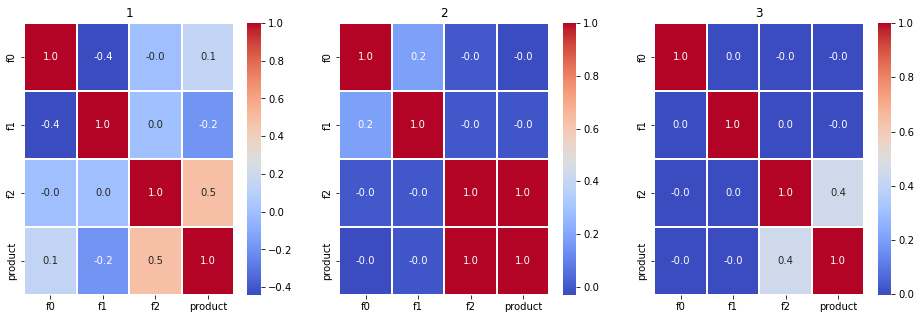

In [8]:
# plot heatmap of dataframes
fig, ax = plt.subplots(1, 3, figsize=(16, 5))
for i, j in zip([df1, df2, df3], range(3)):    
    sns.heatmap(i.corr(), annot=True, linewidths=.1, fmt='.1f', ax=ax[j], cmap='coolwarm')
    ax[j].set_title(str(j + 1))

As seen in the heatmap of the input parameters, there is a high correlation between product and f2, which will affect the trainability of the model and the reliability of the results.

### Step 2. Pre-processing

In [10]:
# combine dataframes 
df = pd.concat([df1, df2, df3], axis=0, join='outer', ignore_index=True, copy=True)
df.shape

(300000, 5)

In [11]:
# create features and target
X = df.drop(['id', 'product'], axis=1)
y = df['product']

In order to preserve all available data and eliminate the high correlation between parameters, the Principal Component Analysis (PCA) method is applied. Then, the dimensionality of the data is reduced, which decreases the correlation, as well as increases the speed of data processing.

In [12]:
# PCA diagram
Image(url='https://devopedia.org/images/article/139/4543.1548137789.jpg', 
      width=600, height=400
)

In [13]:
# PCA with a covariance matrix for dimensionality reduction
class PCA_trans():
    def __init__(self, n_comp):
        self.n_comp = n_comp
        self.eigen_values = None
        self.eigen_vectors = None
        
    def transform(self, x):
        return np.dot(x - self.mean, self.projected_matrix.T)
    
    def inverse_transform(self, x):
        return np.dot(x, self.projected_matrix) + self.mean
    
    def fit(self, x):
        self.n_comp = x.shape[1] if self.n_comp is None else self.n_comp
        self.mean = np.mean(x, axis=0)
        
        cov_matrix = np.cov(x - self.mean, rowvar=False)
        
        self.eigen_values, self.eigen_vectors = np.linalg.eig(cov_matrix)
        self.eigen_vectors = self.eigen_vectors.T
        
        self.sorted_comp = np.argsort(self.eigen_values)[::-1]
        
        self.projected_matrix = self.eigen_vectors[self.sorted_comp[:self.n_comp]]
        self.explained_var = self.eigen_values[self.sorted_comp]
        self.explained_var_ratio = self.explained_var / self.eigen_values.sum()

In [17]:
# function to normalize targets
def norm(y):
    y_norm = (y - np.min(y)) / (np.max(y) - np.min(y))
    return y_norm

In [18]:
# split train and validation data by 75/25 
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.25, random_state=777
)

In [19]:
# normalize targets (for PCA)
y_train_pca = norm(y_train)
y_val_pca = norm(y_val)

In [20]:
# reshape targets
y_train_r = y_train.values.reshape(-1, 1)
y_val_r = y_val.values.reshape(-1, 1)

In [21]:
# normalize targets
scaler_n = MinMaxScaler()
y_train_n = scaler_n.fit(y_train_r)
y_val_n = scaler_n.transform(y_val_r)

In [22]:
# standardize features
scaler_s = StandardScaler()
X_train_s = scaler_s.fit_transform(X_train)
X_val_s = scaler_s.transform(X_val)

In [23]:
# PCA with 2 components
pca = PCA_trans(n_comp=2)
pca.fit(X_train_s)

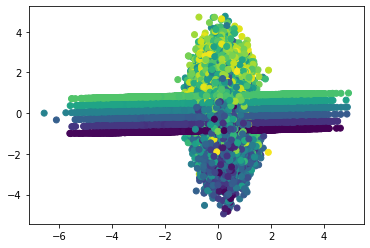

In [24]:
# transform features from 3D to 2D
X_train_t = pca.transform(X_train_s)
X_val_t = pca.transform(X_val_s)
plt.figure()
plt.scatter(X_train_t [:, 0], X_train_t [:, 1], c=y_train_pca);

In [25]:
# transformed features shape
X_train_t.shape

(225000, 2)

In [26]:
# create a transformed dataframe
df_y = pd.DataFrame(norm(y_train))
df_X = pd.DataFrame(X_train_t)
df_anal = pd.concat([df_y, df_X], axis=1, join='outer', ignore_index=False, copy=True)

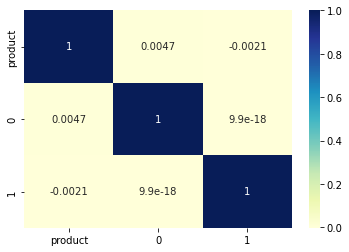

In [27]:
# plot correlation heatmap for the transformed dataframe
fig = sns.heatmap(df_anal.corr(), cmap="YlGnBu", annot=True)
plt.show()

In [28]:
# convert data to pytorch tensors
X_train_s = torch.tensor(X_train_s)
X_train_t = torch.tensor(X_train_t)
y_train_n = torch.tensor(y_train_pca.values)

X_val_s = torch.tensor(X_val_s)
X_val_t = torch.tensor(X_val_t)
y_val_n = torch.tensor(y_val_pca.values)

In [29]:
# generate dataset
class Data(Dataset):

    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.len = len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return self.len    

In [30]:
# create data for training and validation (Neural Network)
train_data_NN = Data(X_train_t, y_train_n)
val_data_NN = Data(X_val_t, y_val_n)

In [31]:
# create data for training and validation (Linear Regression)
train_data_LR = Data(X_train_s, y_train_n)
val_data_LR = Data(X_val_s, y_val_n)

When preparing data for machine learning, all three datasets are combined into one and PCA is applied to reduce the data dimensionality. As a result, the maximum correlation decreases from 1.0 to 0.0047.

### Step 3. Neural Network model training

In [32]:
# set hyperparameters
EPOCHS = 5+1
PRINT_EPOCH = 5
LEARNING_RATE = 0.01
BATCH_SIZE = 64

In [33]:
# dataloaders
train_loader_NN = DataLoader(
    dataset=train_data_NN, 
    batch_size=BATCH_SIZE,
    num_workers=0, 
    shuffle=True, 
    pin_memory=False, 
    drop_last=True
)

val_loader_NN = DataLoader(
    dataset=val_data_NN, 
    batch_size=BATCH_SIZE,  
    num_workers=0, 
    shuffle=True, 
    pin_memory=False
)

Since a machine learning model is being developed for a regression problem, the neural network type is Multilayer Percaptron. Based on the available information, for this type of neural networks consisting of several layers, the ReLU Activation function is applied.

In [34]:
# choose a hidden layer activation function
Image(url='https://machinelearningmastery.com/wp-content/uploads/2020/12/How-to-Choose-an-Hidden-Layer-Activation-Function.png', 
      width=500, height=300
)

Also with regard to theory of regression models, the output layer should be a Linear Activation for subsequent calculation of the residual using the Mean Squared Error Loss function.

In [35]:
# choose an output layer activation function
Image(url='https://machinelearningmastery.com/wp-content/uploads/2020/12/How-to-Choose-an-Output-Layer-Activation-Function.png', 
      width=500, height=300
)

In order to obtain high accuracy of predictions and at the same time avoid overfitting, a 2-(4-4)-1 neural network architecture is chosen, consisting of two input parameters (after dimensionality reduction using PCA), two hidden layers c 4th units each and one output parameter after Linear Activation.

Additionally, to speed up the training process of the model, the Xavier Weight Initialization method is used, so that weights are set with small random values for the initial training point and their distribution is uniform in each layer.

In [36]:
# choose an architecture of the neural network
Image(url='https://miro.medium.com/max/1020/0*Z2Sl7YQUVRJ56kI_.gif', 
      width=500, height=300
)

In [37]:
# define the network
class Net(nn.Module):
     
    def __init__(self):
        super(Net, self).__init__()
        self.hid1 = nn.Linear(2, 4) # 2-(4-4)-1
        self.hid2 = nn.Linear(4, 4)
        self.oupt = nn.Linear(4, 1)

    def forward(self, x):
        z = torch.relu(self.hid1(x))
        z = torch.relu(self.hid2(z))
        z = self.oupt(z) # no activation
        return z

In [38]:
# initialize the weights 
def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

In [39]:
# # RMSE loss function
# class RMSELoss(nn.Module):
    
#     def __init__(self):
#         super(RMSELoss, self).__init__()

#     def forward(self, x, y):
#         criterion = nn.MSELoss()
#         loss = torch.sqrt(criterion(x, y))
#         return loss

In [40]:
# choose an optimizer
Image(url='https://uploads-ssl.webflow.com/60f6b34933666d794d0b878d/60f6b34933666d00b10b8977_table.png', 
      width=900, height=350
)

In [41]:
# model, loss, optimizer
model_NN = Net().to(device)
criterion = nn.MSELoss()
optimizer_NN = optim.Adam(model_NN.parameters(), lr=LEARNING_RATE)  

In [42]:
# apply initialized weights to the model forward pass
with torch.no_grad():
    model_NN.apply(weights_init)

In [43]:
# # calculate accuracy
# def accuracy(oupt, y, pct):
#     n = len(y)

#     # max allowable and actual differences 
#     max_deltas = torch.abs(pct * y)    
#     abs_deltas = torch.abs(oupt.reshape(1, -1)[0] - y)  

#     results = abs_deltas < max_deltas  # [[True, False, . .]]  
#     acc = torch.sum(results, dim=0).item() / n  
#     return acc

In [44]:
# Machine learning process
Image(url='https://drek4537l1klr.cloudfront.net/stevens2/Figures/CH06_F01_Stevens2_GS.png', 
      width=500, height=350
)

In [45]:
# train the model
def training(train_loader, model, optimizer):
    
    train_result = [] 
    for epoch in range(EPOCHS):
        
        iter_loss = 0 
        iter_acc = 0                   
        
        # model training
        model.train()
        for i, data in enumerate(train_loader):
            X, y = data             # (predictors, targets)
            oupt = model(X.float()) # predicted values
            loss = criterion(oupt, y.reshape(-1, 1).float())

            iter_loss += loss       # avg per item in batch

            optimizer.zero_grad()   # prepare gradients
            loss.backward()         # compute gradients
            optimizer.step()        # update weights

            if(epoch == EPOCHS - 1):
                train_result.append((y, oupt.reshape(1, -1)[0]))

        if(epoch % PRINT_EPOCH == 0):
            print('Train: epoch: {0} | loss: {1:.5f}'.format(
                epoch, iter_loss / (i + 1)
                ))  

    return train_result 

In [46]:
# plot training results
train_result_NN = training(train_loader_NN, model_NN, optimizer_NN)

Train: epoch: 0 | loss: 0.03950
Train: epoch: 5 | loss: 0.03470


In [47]:
# validate the model
def testing(val_loader, model):
    
    test_result = [] 
    for epoch in range(EPOCHS):
        
        iter_loss = 0 
        iter_acc = 0                   
        
        # model testing
        model.eval()
        with torch.no_grad():
            for i, data in enumerate(val_loader):
                X, y = data             # (predictors, targets)
                oupt = model(X.float()) # predicted values
                loss = criterion(oupt, y.reshape(-1, 1).float())

                iter_loss += loss       # avg per item in batch

                if(epoch == EPOCHS - 1):
                    test_result.append((y, oupt.reshape(1, -1)[0]))

        if(epoch % PRINT_EPOCH == 0):
            print('Test: epoch: {0} | loss: {1:.5f}'.format(
                epoch, iter_loss / (i + 1)
                ))  

    return test_result 

In [48]:
# plot validation results
val_result_NN = testing(val_loader_NN, model_NN)

Test: epoch: 0 | loss: 0.03485
Test: epoch: 5 | loss: 0.03485


In [49]:
# ground truth values are in 1st list and predictions in 2nd
true_NN, pred_NN = zip(*val_result_NN)
true_NN, pred_NN = torch.cat(true_NN), torch.cat(pred_NN)

In [50]:
# function to de-normalize targets
def inverse_norm(y, y_norm):
    y_virgin = y_norm * (np.max(y) - np.min(y))
    return y_virgin

In [51]:
# de-normalized targets
true_NN = inverse_norm(y, true_NN)
pred_NN = inverse_norm(y, pred_NN)

In [52]:
# average of predicted targets
pred_avg_NN = round(torch.mean(pred_NN).item(), 2)
print('An average of the predicted targets:', pred_avg_NN)

An average of the predicted targets: 81.28


Model validation shows good results: Loss is around 0.03, while the model training time is about 1.5 minutes to ensure the necessary convergence. The result is achieved due to correctly selected hyper-parameters (learning rate = 0.01, batch size = 64, epochs = 5), as well as the use of PCA, Adam optimizer and neural network architecture with two hidden layers.

### Step 4. Linear Regression model training

In [53]:
# dataloaders
train_loader_LR = DataLoader(
    dataset=train_data_LR, 
    batch_size=BATCH_SIZE,
    num_workers=0, 
    shuffle=True, 
    pin_memory=False, 
    drop_last=True
)

val_loader_LR = DataLoader(
    dataset=val_data_LR, 
    batch_size=BATCH_SIZE,  
    num_workers=0, 
    shuffle=True, 
    pin_memory=False
)

In [54]:
# Linear Regression
Image(url='https://miro.medium.com/max/1400/1*AH11fnsdgf8cdB_NB4ti5g.png', 
      width=500, height=300
)     

In [55]:
# define the network
class Linear(nn.Module):
     
    def __init__(self):
        super(Linear, self).__init__()
        self.linear = torch.nn.Linear(3, 1)
     
    def forward(self, x):
        oupt = self.linear(x)
        return oupt  

In [56]:
# model, loss, optimizer
model_LR = Linear().to(device)
optimizer_LR = optim.Adam(model_LR.parameters(), lr=LEARNING_RATE)  

In [57]:
# plot training results
train_result_LR = training(train_loader_LR, model_LR, optimizer_LR)

Train: epoch: 0 | loss: 0.04663
Train: epoch: 5 | loss: 0.04209


In [58]:
# plot validation results
val_result_LR = testing(val_loader_LR, model_LR)

Test: epoch: 0 | loss: 0.04202
Test: epoch: 5 | loss: 0.04202


In [59]:
# ground truth values are in 1st list and predictions in 2nd
true_LR, pred_LR = zip(*val_result_LR)
true_LR, pred_LR = torch.cat(true_LR), torch.cat(pred_LR)

In [60]:
# de-normalized targets
true_LR = inverse_norm(y, true_LR)
pred_LR = inverse_norm(y, pred_LR)

In [61]:
# average of predicted targets
pred_avg_LR = round(torch.mean(pred_LR).item(), 2)
print('An average of the predicted targets:', pred_avg_LR)

An average of the predicted targets: 87.32


Model validation also demonstrates good results: Loss is around 0.04, while the model training time is about 0.5, which is due to the relative simplicity of the linear model. The result is achieved on data without preprocessing and PCA.

### Step 5. Models testing

In [62]:
# split validation data into 3 test subsets
X_test = np.array_split(X_val, 3)
y_test = np.array_split(y_val, 3)

#### Region 1 - Data transformation

In [64]:
# standardize, transform, reshape, normalize
X1_s = scaler_s.transform(X_test[0])
X1_t = pca.transform(X1_s)
y1_r = y_test[0].values.reshape(-1, 1)
y1_pca = norm(y_test[0])
y1_n = scaler_n.transform(y1_r)

In [65]:
# convert data to pytorch tensors
X1_s = torch.tensor(X1_s)
X1_t = torch.tensor(X1_t)
y1_n = torch.tensor(y1_n)
y1_pca = torch.tensor(y1_pca.values)

#### Region 1 - Neural Network

In [66]:
# create data for testing
test_data1_NN = Data(X1_t, y1_pca)

In [67]:
# dataloader
test_loader1_NN = DataLoader(
    dataset=test_data1_NN, 
    batch_size=BATCH_SIZE,
    num_workers=0, 
    shuffle=True, 
    pin_memory=False, 
    drop_last=True
)

In [68]:
# plot test results
test_result1_NN = testing(test_loader1_NN, model_NN)

Test: epoch: 0 | loss: 0.03473
Test: epoch: 5 | loss: 0.03471


In [69]:
# ground truth and predictions
true1_NN, pred1_NN = zip(*test_result1_NN)
true1_NN, pred1_NN = torch.cat(true1_NN), torch.cat(pred1_NN)

In [70]:
# de-normalized targets
true1_NN = inverse_norm(y_test[0], true1_NN)
pred1_NN = inverse_norm(y_test[0], pred1_NN)

#### Region 1 - Linear Regression

In [71]:
# create data for testing
test_data1_LR = Data(X1_s, y1_n)

In [72]:
# dataloader
test_loader1_LR = DataLoader(
    dataset=test_data1_LR, 
    batch_size=BATCH_SIZE,
    num_workers=0, 
    shuffle=True, 
    pin_memory=False, 
    drop_last=True
)

In [73]:
# plot test results
test_result1_LR = testing(test_loader1_LR, model_LR)

Test: epoch: 0 | loss: 0.04186
Test: epoch: 5 | loss: 0.04188


In [74]:
# ground truth and predictions
true1_LR, pred1_LR = zip(*test_result1_LR)
true1_LR, pred1_LR = torch.cat(true1_LR), torch.cat(pred1_LR)

In [75]:
# de-normalized targets
true1_LR = inverse_norm(y_test[0], true1_LR)
pred1_LR = inverse_norm(y_test[0], pred1_LR)

#### Region 1 - Results

In [76]:
# average of predicted targets
pred1_NN_avg = round(torch.mean(pred1_NN).item(), 2)
pred1_LR_avg = round(torch.mean(pred1_LR).item(), 2)
print('Predicted targets of the 1st region (Neural Network):', pred1_NN_avg)
print('Predicted targets of the 1st region (Linear Regression):', pred1_LR_avg)

Predicted targets of the 1st region (Neural Network): 81.36
Predicted targets of the 1st region (Linear Regression): 87.35


#### Region 2 - Data transformation

In [77]:
# standardize, transform, reshape, normalize
X2_s = scaler_s.transform(X_test[1])
X2_t = pca.transform(X2_s)
y2_r = y_test[1].values.reshape(-1, 1)
y2_pca = norm(y_test[1])
y2_n = scaler_n.transform(y2_r)

In [78]:
# convert data to pytorch tensors
X2_s = torch.tensor(X2_s)
X2_t = torch.tensor(X2_t)
y2_n = torch.tensor(y2_n)
y2_pca = torch.tensor(y2_pca.values)

#### Region 2 - Neural Network

In [79]:
# create data for testing
test_data2_NN = Data(X2_t, y2_pca)

In [80]:
# dataloader
test_loader2_NN = DataLoader(
    dataset=test_data2_NN, 
    batch_size=BATCH_SIZE,
    num_workers=0, 
    shuffle=True, 
    pin_memory=False, 
    drop_last=True
)

In [81]:
# plot test results
test_result2_NN = testing(test_loader2_NN, model_NN)

Test: epoch: 0 | loss: 0.03521
Test: epoch: 5 | loss: 0.03520


In [82]:
# ground truth and predictions
true2_NN, pred2_NN = zip(*test_result2_NN)
true2_NN, pred2_NN = torch.cat(true2_NN), torch.cat(pred2_NN)

In [83]:
# de-normalized targets
true2_NN = inverse_norm(y_test[1], true2_NN)
pred2_NN = inverse_norm(y_test[1], pred2_NN)

#### Region 2 - Linear Regression

In [84]:
# create data for testing
test_data2_LR = Data(X2_s, y2_n)

In [85]:
# dataloader
test_loader2_LR = DataLoader(
    dataset=test_data2_LR, 
    batch_size=BATCH_SIZE,
    num_workers=0, 
    shuffle=True, 
    pin_memory=False, 
    drop_last=True
)

In [86]:
# plot test results
test_result2_LR = testing(test_loader2_LR, model_LR)

Test: epoch: 0 | loss: 0.04219
Test: epoch: 5 | loss: 0.04218


In [87]:
# ground truth and predictions
true2_LR, pred2_LR = zip(*test_result2_LR)
true2_LR, pred2_LR = torch.cat(true2_LR), torch.cat(pred2_LR)

In [88]:
# de-normalized targets
true2_LR = inverse_norm(y_test[1], true2_LR)
pred2_LR = inverse_norm(y_test[1], pred2_LR)

#### Region 2 - Results

In [89]:
# average of predicted targets
pred2_NN_avg = round(torch.mean(pred2_NN).item(), 2)
pred2_LR_avg = round(torch.mean(pred2_LR).item(), 2)
print('Predicted targets of the 2nd region (Neural Network):', pred2_NN_avg)
print('Predicted targets of the 2nd region (Linear Regression):', pred2_LR_avg)

Predicted targets of the 2nd region (Neural Network): 81.23
Predicted targets of the 2nd region (Linear Regression): 87.24


#### Region 3 - Data transformation

In [90]:
# standardize, transform, reshape, normalize
X3_s = scaler_s.transform(X_test[2])
X3_t = pca.transform(X3_s)
y3_r = y_test[2].values.reshape(-1, 1)
y3_pca = norm(y_test[2])
y3_n = scaler_n.transform(y3_r)

In [91]:
# convert data to pytorch tensors
X3_s = torch.tensor(X3_s)
X3_t = torch.tensor(X3_t)
y3_n = torch.tensor(y3_n)
y3_pca = torch.tensor(y3_pca.values)

#### Region 3 - Neural Network

In [92]:
# create data for testing
test_data3_NN = Data(X3_t, y3_pca)

In [93]:
# dataloader
test_loader3_NN = DataLoader(
    dataset=test_data3_NN, 
    batch_size=BATCH_SIZE,
    num_workers=0, 
    shuffle=True, 
    pin_memory=False, 
    drop_last=True
)

In [94]:
# plot test results
test_result3_NN = testing(test_loader3_NN, model_NN)

Test: epoch: 0 | loss: 0.03473
Test: epoch: 5 | loss: 0.03471


In [95]:
# ground truth and predictions
true3_NN, pred3_NN = zip(*test_result3_NN)
true3_NN, pred3_NN = torch.cat(true3_NN), torch.cat(pred3_NN)

In [96]:
# de-normalized targets
true3_NN = inverse_norm(y_test[2], true3_NN)
pred3_NN = inverse_norm(y_test[2], pred3_NN)

#### Region 3 - Linear Regression

In [97]:
# create data for testing
test_data3_LR = Data(X3_s, y3_n)

In [98]:
# dataloader
test_loader3_LR = DataLoader(
    dataset=test_data3_LR, 
    batch_size=BATCH_SIZE,
    num_workers=0, 
    shuffle=True, 
    pin_memory=False, 
    drop_last=True
)

In [99]:
# plot test results
test_result3_LR = testing(test_loader3_LR, model_LR)

Test: epoch: 0 | loss: 0.04197
Test: epoch: 5 | loss: 0.04195


In [100]:
# ground truth and predictions
true3_LR, pred3_LR = zip(*test_result3_LR)
true3_LR, pred3_LR = torch.cat(true3_LR), torch.cat(pred3_LR)

In [101]:
# de-normalized targets
true3_LR = inverse_norm(y_test[2], true3_LR)
pred3_LR = inverse_norm(y_test[2], pred3_LR)

#### Region 3 - Results

In [102]:
# average of predicted targets
pred3_NN_avg = round(torch.mean(pred3_NN).item(), 2)
pred3_LR_avg = round(torch.mean(pred3_LR).item(), 2)
print('Predicted targets of the 3rd region (Neural Network):', pred3_NN_avg)
print('Predicted targets of the 3rd region (Linear Regression):', pred3_LR_avg)

Predicted targets of the 3rd region (Neural Network): 81.17
Predicted targets of the 3rd region (Linear Regression): 87.24


Using model predictions, the average volume of oil in Region 1 is 92.51, and in Region 2 - 68.83, in Region 3 - 94.98. At the same time, Loss for the results in Regions 1 and 3 is 0.2, and in Region 2 - 0.01.

### Step 6. Revenue calculation

Given figures for calculating revenue from oil wells

In [103]:
BUDGET = 10e+6 # x1000 - total budget to develop oil wells in the region
INCOME = 450 # x1000 - income from 1(x1000) oil well
TOTAL_WELLS = 500 # all exploring wells 
PROFIT_WELLS = 200 # profitable wells 

In [104]:
# convert results from pytorch tensor to pandas series 
# for calculating the predicted revenue
true1_calc = pd.Series(true1_LR.detach().cpu().numpy().squeeze())
pred1_calc = pd.Series(pred1_LR.detach().cpu().numpy().squeeze())

true2_calc = pd.Series(true2_LR.detach().cpu().numpy().squeeze())
pred2_calc = pd.Series(pred2_LR.detach().cpu().numpy().squeeze())

true3_calc = pd.Series(true3_LR.detach().cpu().numpy().squeeze())
pred3_calc = pd.Series(pred3_LR.detach().cpu().numpy().squeeze())

Calculation of the cost of drilling one well

In [105]:
# cost for developing a new oil well
cost = BUDGET / (PROFIT_WELLS * 1e+6)
print('Cost for developing a new oil well: {} billion rub'.format(cost))

Cost for developing a new oil well: 0.05 billion rub


Calculation of the optimal oil volume for the development of one well

In [106]:
# optimal storage of oil for the well
optimal_storage = (cost * 1e+6) / INCOME 
print('Storage for a new oil well: {:.2f} thousand barrels'.format(optimal_storage))

Storage for a new oil well: 111.11 thousand barrels


Based on the calculated optimal oil volume equal to 111.11 thousand barrels, it can be concluded that the predicted values for the three regions (92.51, 68.83, 94.98) are less than necessary.

Well revenue calculation based on machine learning model predictions

In [107]:
# calculate revenue (billion rub)
def revenue_calc(true, pred, count):
    pred_sorted = pred.sort_values(ascending=False)
    selected = true[pred_sorted.index][:count]
    
    return (INCOME * selected.sum() - BUDGET) / 1e+6

Random selection of 500 points for production and calculation of revenue from the top 200 new wells

In [108]:
# statistics of revenue from top-200 oil wells
def revenue_stat(true, pred, count):    
    revenue = []

    for i in range(1000):
        true = pd.Series(true)
        true_sub = true.sample(n=TOTAL_WELLS, replace=True, random_state=state)
        pred_sub = pred.loc[true_sub.index]
        revenue.append(revenue_calc(true_sub, pred_sub, PROFIT_WELLS))

    return revenue   

Calculation of risks for the development of 200 new wells with a probability of loss below 2.5%

In [109]:
# revenue risk management for top-200 oil wells
def risk_management(revenue):    
    revenue = pd.Series(revenue)
    risk_revenue = (revenue < 0).mean() * 100 # no unit value
    lower, upper = (round(revenue.quantile(0.025), 2), 
                    round(revenue.quantile(0.975), 2))
    revenue = revenue[(revenue > 0) & (revenue > lower) & (revenue < upper)]
    avg_revenue = revenue.mean()
          
    return avg_revenue, risk_revenue, lower, upper

In [110]:
# function to plot final results
def results():
    
    avg_revenue1, risk_revenue1, lower1, upper1 = \
        risk_management(revenue_stat(true1_calc, pred1_calc, PROFIT_WELLS))

    avg_revenue2, risk_revenue2, lower2, upper2 = \
        risk_management(revenue_stat(true2_calc, pred2_calc, PROFIT_WELLS))

    avg_revenue3, risk_revenue3, lower3, upper3 = \
        risk_management(revenue_stat(true3_calc, pred3_calc, PROFIT_WELLS))

    results = {
        'Region': ['Region 1', 'Region 2', 'Region 3'], 
        'Revenue': [avg_revenue1, avg_revenue2, avg_revenue3],
        'Risks': [risk_revenue1, risk_revenue2, risk_revenue3],
        'Con. interval': [(lower1, upper1), (lower2, upper2), (lower3, upper3)]
    }
    display(pd.DataFrame(results))

In [111]:
# plot final results
results()

,Region,Revenue,Risks,Con. interval
0,Region 1,0.30,16.8,"(-0.24, 0.73)"
1,Region 2,0.31,17.8,"(-0.3, 0.75)"
2,Region 3,0.30,22.2,"(-0.29, 0.68)"


Revenue calculation shows that Region 1 is the best option for investment, since the risks of losses are minimal and at the same time the forecasted income is high.

### Conclusions

In accordance with the objectives of the research, a machine learning model is built and the calculation of revenue depending on the location of oil wells is carried out.

At the initial stage, the data is processed using Principal Component Analysis. There are three features f1, f2, f3 strongly correlated with product. The PCA algorithm finds a feature combination and expresses these features with two new features by summing the mutual variances determined from the Covariance matrix. Next, the direction of eigenvector is determined and the point cloud is projected onto it, which leads to a reduction in the dimension and correlation between the parameters.

To build a machine learning model, the Multilayer Percaptron neural network architecture is used, which performs two sequential operations: calculating the sum of the input parameters updated after PCA (f0 and f1), taking into account their weight, and using the Activation function to perform the differentiation operation.

The learning process includes forward pass, MSE residual calculation, and backpropagation. At the first step, the tensors of parameters and weight are multiplied, and the predictor (pred) is calculated. Next, the difference between the actual (true) and calculated (pred) values ​​is calculated. At the end, weight is modified to find the local minimum of the function using the gradient descent algorithm.

As a result, the validation shows a fairly high efficiency of the model for this task, Loss is around 0.03, while the model training time is about 1.5 minutes on an i7 CPU (32gb RAM).

Additionally, a Linear Regression model is built to verify the Neural Network model and check the correctness of the results, which determines the dependence of the target feature 'y' on the independent variables 'X' using a linear function.

The business forecast is made using the results of this machine learning model for oil volumes in three regions based on statistical data. According to the well development budget of 10 billion rubles and the price of a barrel of oil of 450 rubles, a profit calculation is performed, which shows that Region 2 is optimal for investment due to the low risk of losses (about 2) and high income, equal to approximately 0.4 billion rubles.